# Image inpainting over CIFAR-10

The purpose of this project is to build and train a neural network for image inpainting over the CIFAR-10 dataset. 

Inpainting is a restauration process where damaged, deteriorated, or missing parts of an artwork are filled in to present a complete image.

In our case, we create the portion of the image to be filled in by cropping a fixed size rectangular area from CIFAR-10 images.

The networks must be trained over the training set, and tested on the test set.
You can split the train set into a validation set, if you wish.

The metrics that will be used to evaluate you result is Mean Square Error.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.datasets import cifar10

Here we load the dataset.

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)
print("new image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))

170498071/170498071 [==============================] - 13s 0us/step
image range is 0, 255
new image range is 0.0, 1.0


Let's see some examples.

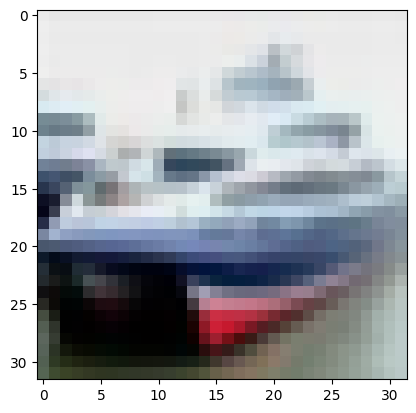

(32, 32, 3)


In [6]:
plt.imshow(x_test[1])
plt.show()
print(x_train[0].shape)

Now we hide a portion of the input, and the purpose of the network is to reconstruct it.

In [4]:
def mask(X,coords):
  x0,y0,x1,y1 = coords
  X[:,x0:x1,y0:y1] = 0
  return X

masked_x_train = mask(np.copy(x_train),(2,16,30,30))
masked_x_test = mask(np.copy(x_test),(2,16,30,30))

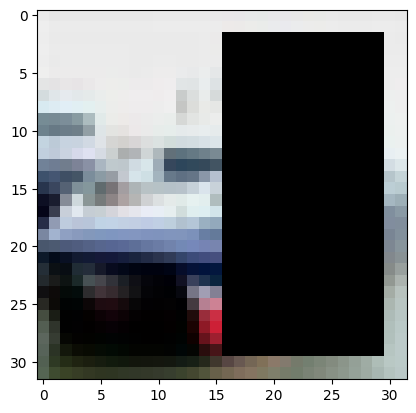

In [8]:
plt.imshow(masked_x_test[1])
plt.show()

# Approaches and evaluation

The network is supposed to take in input the masked image and fill in the missing part. 

You may basically follow two main approaches:
*   either you return the full image
*   you just return the missing crop

In the first case, the mse is to be evaluated on the full image; in the second case just on the crop (since on the reamining part is 0). 

If you want to take a different approach, you can ask for my approuval.



# What to deliver

As usual, you are supposed to deliver a single notebook comprising the code, the training history, and the evaluation on test data in terms of Mean Square Error.

Good work!

In [5]:
from tensorflow.keras.layers import BatchNormalization, concatenate, Conv2D, Conv2DTranspose, Dense, Dropout, Flatten, Input, Lambda, LeakyReLU, MaxPooling2D, ReLU, Rescaling, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

(32, 32, 3)


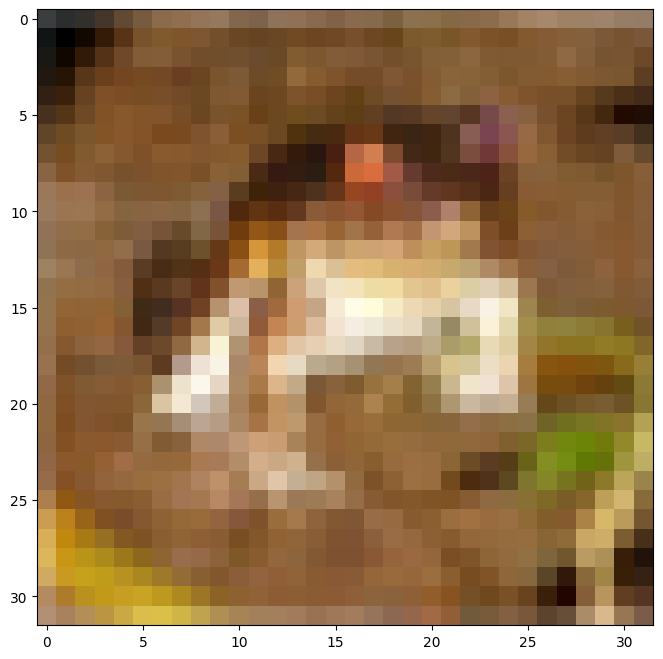

In [17]:
#replace_black_box = lambda img, rep: np.where(img[:, 10:21, 10:21] == 0, rep[:, 10:21, 10:21], img)
#replace_black_box = lambda img, new_img: img.copy()[:, 10:21, 10:21] = new_img[:, 10:21, 10:21]
# replace_black_box = lambda x: tf.where(x[0][:, 10:21, 10:21] == 0, x[1][:, 10:21, 10:21], x[0][:, 10:21, 10:21])
replace_black_box = lambda x: np.where(x[0][:] == 0, x[1][:], x[0][:])

# def mask(X,coords):
#   x0,y0,x1,y1 = coords
#   X[:,x0:x1,y0:y1] = 0
#   return X

# masked_x_train = mask(np.copy(x_train),(2,16,30,30))
# masked_x_test = mask(np.copy(x_test),(2,16,30,30))

a = replace_black_box([masked_x_train[0], x_train[0]])
print(a.shape)
plt.figure(figsize=(15, 8))

plt.imshow(a)

plt.show()

In [6]:
def get_network(input_shape=(32,32,3), n_ch=32, num_layer=4, num_loop_per_layer=2):
  #crop_input = Lambda(lambda x: x[:,2:30,16:30])
  # replace_black_box = Lambda(lambda img, rep: np.where(img[:, 10:21, 10:21] == 0, rep[:, 10:21, 10:21], img))
  replace_black_box = Lambda(lambda x: tf.where(x[0][:] == 0, x[1][:], x[0][:]))

  x_out = 14
  y_out = 28

  x = Input(input_shape)
  #x = crop_input(x)
  c1 = x
  backup_layers = []

  for i in range(num_layer):

    for j in range(num_loop_per_layer):
      c1 = Conv2D(n_ch, kernel_size=3, padding='same')(c1)
      # c1 = BatchNormalization()(c1)
      c1 = ReLU()(c1)

    if (i < num_layer - 1):
      backup_layers.append(c1)
      c1 = MaxPooling2D(padding='same')(c1)

      n_ch *= 2


  for i in range(num_layer - 1):
    n_ch = n_ch // 2
    c1 = Conv2DTranspose(n_ch, 3, 2, padding='same')(c1)
    c1 = concatenate([c1, backup_layers.pop(-1)])

    for c in range(num_loop_per_layer):
      c1 = Conv2D(n_ch, 3, 1, padding='same')(c1)
      c1 = ReLU()(c1)

  y = Conv2D(3,1, activation='sigmoid')(c1)
  y = replace_black_box([x,y]) 

  model = Model(x,y)
  print(model.summary())
  return model


In [7]:
network = get_network(n_ch=64, num_layer=5)

network.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='mse',
                  metrics=['mse'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 re_lu (ReLU)                   (None, 32, 32, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['re_lu[0][0]']                  
                                                                                              

# Training

In [8]:
BATCH_SIZE = 64
N_EPOCHS = 100

callback = EarlyStopping(monitor="val_loss",
    # min_delta=0.0005,
    patience=10,
    restore_best_weights=True)

history = network.fit(masked_x_train, x_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS, 
                      validation_split=0.1, callbacks=[callback])



Epoch 1/100
704/704 [==============================] - 93s 102ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 2/100
704/704 [==============================] - 67s 94ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 3/100
704/704 [==============================] - 67s 95ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 4/100
704/704 [==============================] - 67s 94ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 5/100
704/704 [==============================] - 67s 95ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 6/100
704/704 [==============================] - 67s 94ms/step - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 7/100
704/704 [==============================] - 66s 94ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 8/100
704/704 [==============================] -

In [38]:
network.save('weights')

In [40]:
!zip -r weights.zip weights

  adding: weights/ (stored 0%)
  adding: weights/variables/ (stored 0%)
  adding: weights/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: weights/variables/variables.index (deflated 73%)
  adding: weights/assets/ (stored 0%)
  adding: weights/fingerprint.pb (stored 0%)
  adding: weights/saved_model.pb (deflated 90%)
  adding: weights/keras_metadata.pb (deflated 95%)


In [8]:
!unzip weights.zip

Archive:  weights.zip
   creating: weights/
   creating: weights/variables/
  inflating: weights/variables/variables.data-00000-of-00001  
  inflating: weights/variables/variables.index  
   creating: weights/assets/
 extracting: weights/fingerprint.pb  
  inflating: weights/saved_model.pb  
  inflating: weights/keras_metadata.pb  


In [12]:
network.load_weights('weights')

In [22]:
network.evaluate(masked_x_test, x_test)

313/313 [==============================] - 6s 20ms/step - loss: 0.0083 - mse: 0.0083


[0.00827509444206953, 0.00827509444206953]

In [23]:
a = np.zeros((x_test.shape[0],32,32,3))
a = a+1
print(a.shape, masked_x_test.shape)

network.evaluate(masked_x_test, a)

(10000, 32, 32, 3) (10000, 32, 32, 3)
313/313 [==============================] - 6s 20ms/step - loss: 0.3297 - mse: 0.3297


[0.32970842719078064, 0.32970842719078064]

1/1 [==============================] - 1s 1s/step


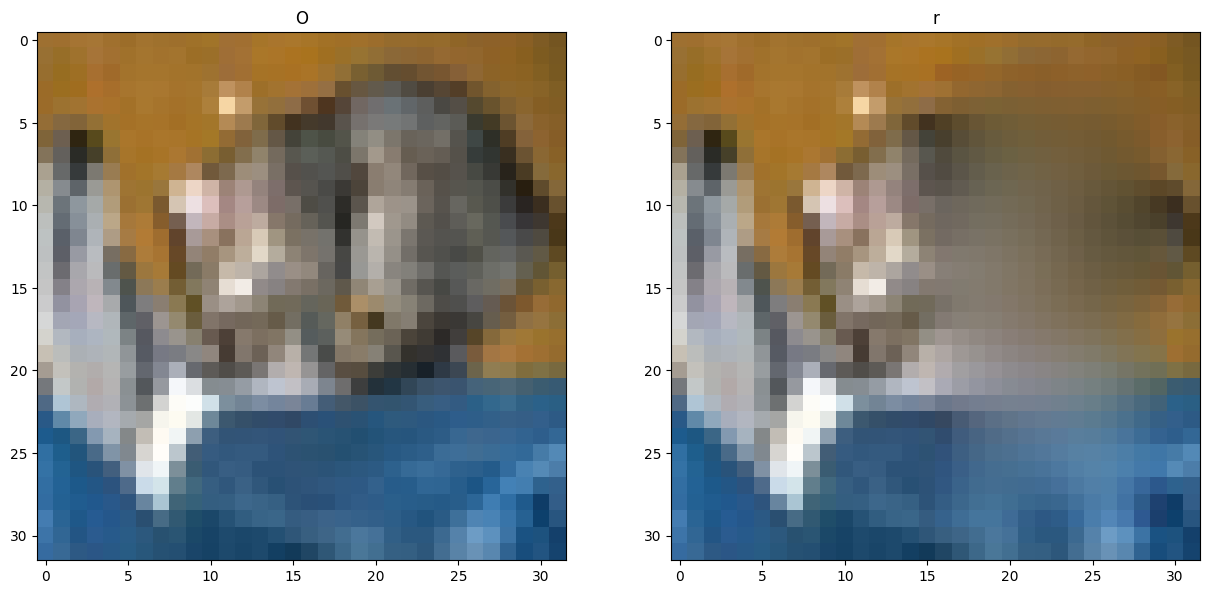

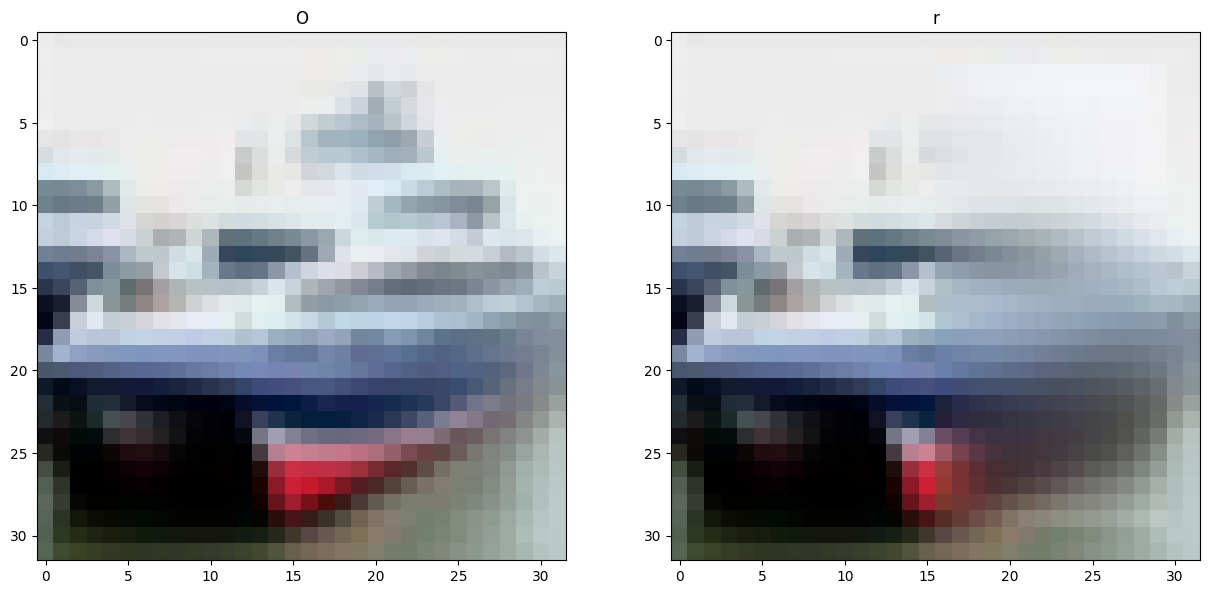

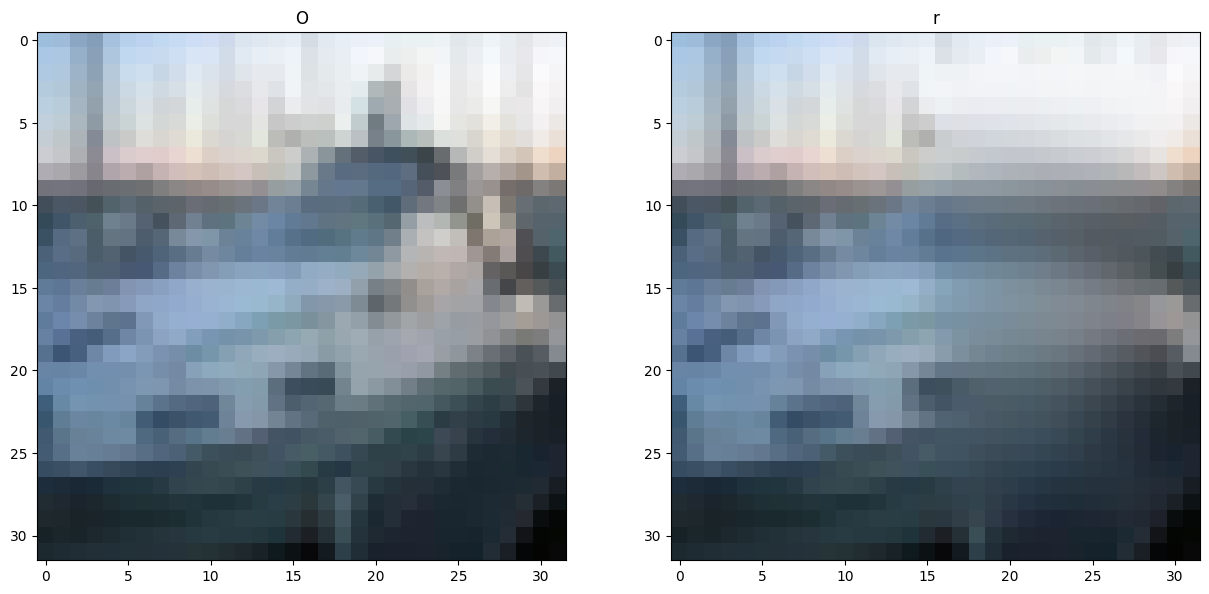

In [9]:
def show(x, y, title=None):
    plt.figure(figsize=(15, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(x)
    if title:
        plt.title(title[0])
    
    plt.subplot(1, 2, 2)
    plt.imshow(y)
    if title:
        plt.title(title[1])

    plt.show()

pred = network.predict(masked_x_test[:3], batch_size=3)
show(x_test[0], pred[0], title='Original')
show(x_test[1], pred[1], title='Original')
show(x_test[2], pred[2], title='Original')